This project aims to build an advanced RAG (Retrieval-Augmented Generation) system with an agent that can perform various tasks, including web searching and relevance checking, using the LangGrapgh library.


**Indexing**


In [1]:
from typing import List, Dict, Any
from langchain_core.documents.base import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
import chromadb
from langchain_chroma import Chroma
from langchain.retrievers import EnsembleRetriever, BM25Retriever
from langchain_core.vectorstores.base import VectorStoreRetriever
from dotenv import load_dotenv
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Load the PDF file
pdf_path = "google-2023-environmental-report.pdf"
loader = PyPDFLoader(file_path=pdf_path, mode="single")
documents: List[Document] = loader.load()

# Create a embedding object
load_dotenv()
embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")

# Split the documents into chunks
chunker = SemanticChunker(embeddings=embedding_function)
chunks: List[Document] = chunker.split_documents(documents)
print(f"Split PDF into {len(chunks)} chunks.\n")

Split PDF into 102 chunks.



In [2]:
# Create a Chroma vector store
chroma_client = chromadb.Client()
collection_name = "google_environmental_report"

chroma_vector_store: Chroma = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_function,
    collection_name=collection_name,
    client=chroma_client,
)

# Create a BM25 retriever
sparse_retriever: BM25Retriever = BM25Retriever.from_documents(
    documents=chunks,
    k=5
)
# Create a Chroma retriever
dense_retriever: VectorStoreRetriever = chroma_vector_store.as_retriever(
    search_kwargs={"k": 5}
)
# Create an ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[dense_retriever, sparse_retriever],
    weights=[0.5, 0.5],
    c=0, # c=0 means no re-ranking
    k=10
)

**Tools**


In [3]:
# Define the tools that will be used by the agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools.simple import Tool

# Add a web-search tool
# Tavily Search is a web search engine specifically designed for LLMs and agents.
web_search = TavilySearchResults(max_results=4)
web_search_name: str = web_search.name

# Check the web-search tool
web_search.invoke("What are Google's environmental initiatives?")

[{'title': "Google's 2024 Environmental Report: Key Insights and Opportunities",
  'url': 'https://climateinsider.com/2024/07/04/googles-2024-environmental-report-key-insights-and-opportunities/',
  'content': 'These initiatives highlight Google’s proactive approach to leveraging technology for environmental sustainability, spanning sectors including transportation, energy efficiency, climate adaptation, and smart city development.\n\nRead also: Top Climate Tech Trends & Innovations in 2024 and Beyond\n\nAI for Sustainability [...] Google’s efforts to become a circular economy leader are also emphasised in the report. The company is focused on reducing waste, reusing materials, and designing products with sustainability in mind. By prioritising a circular approach, Google aims to minimise its environmental impact and promote long-term sustainability. [...] A feature initiative of the company can be found in the recent partnership with The Nature Conservancy which focuses on supporting 

In [4]:
# Create a retriever tool
retriever_tool: Tool = create_retriever_tool(
    retriever=ensemble_retriever,
    name="retrieve_google_environmental_information_for_question_answering",
    description="Extensive information about Google environmental efforts from the 2023 report."
)
retriever_tool_name: str = retriever_tool.name

# Define a list of tools for the agent
tools: List[Tool | TavilySearchResults] = [retriever_tool, web_search]

**Agent State**<br>
<br>
Agent State is a key component of any agent with LangGraph. Using LangGraph, an **AgentState** class is created to establish the “state” for your agent and track it over time.


In [5]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


# Create AgentState class to store and check the state of the agent 
class AgentState(TypedDict):
    # For the RAG agent, set the state to be a list of messages.
    messages: Annotated[Sequence[BaseMessage], add_messages]


# Define the prompt template for generation
generation_prompt: PromptTemplate = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know. Provide a thorough description to fully answer the question, 
    utilizing any relevant information you found.

    Question: {question}
    Context: {context}

    Answer:"""
)

# Define the two LLMs, one for generation and one for the agent
# The generation LLM is used to generate the answer based on the retrieved context.
llm_generation: ChatOpenAI = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)
llm_agent: ChatOpenAI = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

**Nodes and Edges**


In [6]:
# Define a conditional edge function that determines if the retrieved documents are relevant to the question.
def score_documents(state: AgentState) -> Literal["generate", "improve"]:
    """
    This function scores the documents and decides whether to generate an answer or improve the documents.
    """
    
    print("---CHECK RELEVANCE---")

    # Build the scoring model
    class ScoringModel(BaseModel):
        """
        This model is used to score the documents.
        """
        score: str = Field(description="Relevance score of the retrieved documents.")

    # add the LLM that will make the decision:
    llm_with_tool = llm_generation.with_structured_output(schema=ScoringModel)

    # Prompt
    prompt = PromptTemplate(
        template="""Given the following question and retrieved context, determine if the context is relevant enough to the question. 
        Provide a score from 1 to 5, where 1 is not at all relevant and 5 is highly relevant.
        Return ONLY the numeric score, without any additional text or explanation.

        Question: {question}
        Retrieved Context: {context}

        Relevance Score:""",
        input_variables=["question", "context"]
    )

    # Chain for scoring documents
    chain = prompt | llm_with_tool

    # pull in the state
    messages = state["messages"]  # The list of messages in the conversation
    last_message = messages[-1]  
    question = messages[0].content  # The content of  first message is assumed to be the user’s question.
    docs = last_message.content  # The content of last message is assumed to be the retrieved documents.

    # Call the chain with the last message and question
    scored_result = chain.invoke({"question": question, "context": docs})
    score = float(scored_result.score.strip())

    if score >= 4:
        print(f"---RELEVANCE SCORE: {score}, DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print(f"---RELEVANCE SCORE: {score}, DECISION: DOCS NOT RELEVANT ENOUGH---")
        return "improve"


In [7]:
# Agent node - invokes the agent model to generate a response based on the current state. 
# Decision choices (given the question): retrieve using the retriever tool, web_search tool, both, or end.
def agent(state: AgentState) -> Dict[str, Any]:
    
    print("---CALL AGENT---")
    messages = state["messages"]
    llm = llm_agent.bind_tools(tools=tools)
    response = llm.invoke(messages)
    
    return {"messages": [response]} # Return list, will get added to existing list


# Define the improve node function that is responsible for transforming user_query to produce a better question 
# if the agent determines that it is needed.
def improve(state: AgentState) -> Dict[str, Any]:

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(content=f"""\n 
            Look at the input and try to reason about the underlying semantic intent / meaning. \n 
            Here is the initial question:
            \n ------- \n
            {question} 
            \n ------- \n
            Formulate an improved question: 
            """
        )
    ]
    # Scoring
    response: BaseMessage = llm_generation.invoke(msg)
    
    return {"messages": [response]}


# Generate node - generate answer
def generate(state: AgentState) -> Dict[str, Any]:

    print("---GENERATE---")
    # Pull in the messages
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Chain
    rag_chain = generation_prompt | llm_generation | StrOutputParser()

    # Run
    response: str = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

**Graph Setup**


In [8]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

#  Create a new instance of StateGraph
workflow = StateGraph(state_schema=AgentState)

# Add the agent node
workflow.add_node(node="agent", action=agent)

# Add the tool node
retrieve = ToolNode(tools)
workflow.add_node(node="retrieve", action=retrieve)

# Add the improve node
workflow.add_node(node="improve", action=improve)

# Add the generate node
workflow.add_node(node="generate", action=generate)

# Define the starting point for the workflow:
workflow.set_entry_point("agent")

In [9]:
# Next, call the "agent" node to decide whether to retrieve or not:
workflow.add_conditional_edges(
    source="agent", 
    path=tools_condition,  # Use the tools_condition function to determine the next node: ["tools", "__end__"]
    # Translate the condition outputs to nodes in our graph
    path_map={
        "tools": "retrieve",
        END: END,
    },
)

# Add the conditional edge for the scoring function
workflow.add_conditional_edges("retrieve", score_documents)  # score_documents returns either "generate" or "improve".

# Add the edges between nodes
workflow.add_edge("generate", END)
workflow.add_edge("improve", "agent")

# Compile
graph = workflow.compile()

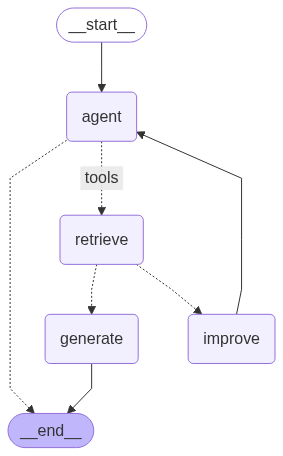

In [10]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

**Invoking the Graph**


In [11]:
user_query = "What are Google's environmental initiatives?"

# Initialize the state with the user query
inputs = {
    "messages": [HumanMessage(content=user_query)]
}
# Run the workflow
result = graph.invoke(inputs)
result

---CALL AGENT---
---CHECK RELEVANCE---
---RELEVANCE SCORE: 5.0, DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content="What are Google's environmental initiatives?", additional_kwargs={}, response_metadata={}, id='1174ab58-5811-482c-8861-48fb40166d7d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Bam4IQBL7GobVdWLi6gw3d50', 'function': {'arguments': '{"query":"Google environmental initiatives"}', 'name': 'retrieve_google_environmental_information_for_question_answering'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 128, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_92e0377081', 'id': 'chatcmpl-BZlgn6y9zGvcHdwAPTC53tr4IJI3R', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fb3511bb-74b9-4b14

In [ ]:
print("Agent message about tool calls: \n", result["messages"][1].tool_calls)  # shows the retriever tool call
print("\n---FINAL RESULT---")
print(result["messages"][-1].content)

Agent message about tool calls: 
 [{'name': 'retrieve_google_environmental_information_for_question_answering', 'args': {'query': 'Google environmental initiatives'}, 'id': 'call_Bam4IQBL7GobVdWLi6gw3d50', 'type': 'tool_call'}]

---FINAL RESULT---
Google has implemented a variety of environmental initiatives aimed at addressing climate change and promoting sustainability. Here are some key aspects of their efforts:

1. **Information and Awareness**: Google provides users with information panels and visuals on climate change when they search for related terms. This includes insights on the causes and effects of climate change, as well as actionable steps individuals can take to live more sustainably. They collaborate with authoritative sources like the United Nations to ensure the information is credible.

2. **YouTube Engagement**: The company engages users on environmental topics through YouTube. For instance, on Earth Day 2022, Google launched the "Non-Fungible Planet" campaign, part

In [ ]:
user_query = "How is Google developing its LLMs?"
inputs = {
    "messages": [HumanMessage(content=user_query)]
}
# Run the workflow
result = graph.invoke(inputs)

print("Agent message about tool calls: \n", result["messages"][1].tool_calls)  # shows the web search tool call
print("\n---FINAL RESULT---")
print(result["messages"][-1].content)

---CALL AGENT---
---CHECK RELEVANCE---
---RELEVANCE SCORE: 5.0, DECISION: DOCS RELEVANT---
---GENERATE---
Agent message about tool calls: 
 [{'name': 'tavily_search_results_json', 'args': {'query': 'Google developing LLMs 2023'}, 'id': 'call_YKrmAFzp249angipweRmJ530', 'type': 'tool_call'}]

---FINAL RESULT---
Google is actively developing its large language models (LLMs) through a combination of foundational research, innovative applications, and strategic enhancements to their existing technologies. Here are some key aspects of how Google is advancing its LLMs:

1. **Foundational Research and Innovations**: Google has a strong history of contributing to the foundational technologies that underpin LLMs. Notably, the company was responsible for the breakthrough research on the transformer architecture in 2017, which has become a cornerstone for many modern LLMs. This foundational work has positioned Google as a leader in AI research, although the company has faced challenges in the mark

In [ ]:
# Print the output of each node in the workflow
import pprint

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("--------------------")
        if isinstance(value, list):
            for item in value:
                pprint.pprint(item, indent=4, width=80, depth=None)
        else:
            # Print the value directly
            pprint.pprint(value, indent=4, width=80, depth=None)

---CALL AGENT---
"Output from node 'agent':"
'--------------------'
{   'messages': [   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dk3ixh3rAXSZxp6D3SQUkDUg', 'function': {'arguments': '{"query":"Google developing LLMs 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 131, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_92e0377081', 'id': 'chatcmpl-BZltpumD6JEsVkY2Lv6t7HSRfje0Q', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c184d2d7-df23-46cc-b9fa-b429f2a0d7de-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Google developing LLMs 2023'}, 'id'